### ML Solution pipeline

[Problem](#Problem)  -> [Acquire Data](#Acquire) -> [Prepare Data](#Prepare) ->  [Visualize](#Visualize) -> [FeatureEnginering](#Feature) -> [Model](#Model) -> [Predict](#Predict) -> [Evaluate](#Evaluate) -> [HyperParams Tuning](#Tune) -> [Submission](#Submission)

### Problem[^](#Problem)<a id="Problem" ></a><br>
The problem definition for Titanic Survival competition is described [here](https://www.kaggle.com/c/titanic) at Kaggle.

**Summary:** "what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).  In simple words, based on passenger details we need to predict that person survive or not?

### Acquire Data[^](#Acquire)<a id="Acquire" ></a><br>

Data definition can be found in [here.](https://www.kaggle.com/c/titanic/data)

In [26]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

input_train_df = pd.read_csv('../input/titanic/train.csv')
input_test_df = pd.read_csv('../input/titanic/test.csv')
input_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Prepare Data[^](#Prepare)<a id="Prepare" ></a><br>
Cleaning -> Fill Missing Data -> Create New Features

Cleaning:  remove unwanted features, this will remove unwanted weight we are carring in dataframe

In [27]:
#Cleaning - select required features
cleaned_train_df = input_train_df.drop(['Ticket'],axis=1)
cleaned_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [28]:
#Fill missing data
print(cleaned_train_df.isnull().sum())
cleaned_train_df['Embarked'] = cleaned_train_df['Embarked'].fillna(cleaned_train_df.Embarked.dropna().mode()[0]) 
cleaned_train_df['Age'] = cleaned_train_df['Age'].fillna(cleaned_train_df.Age.dropna().mode()[0]) 
cleaned_train_df['Cabin'] = cleaned_train_df['Cabin'].fillna('NONE')
print(cleaned_train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [29]:
#remove outliers
selectedFetaureForOutliers = ['Pclass','Age','Fare','Parch'] #numeric feilds
dfSelected = cleaned_train_df[selectedFetaureForOutliers]
Q1 = dfSelected.quantile(0.25)
Q3 = dfSelected.quantile(0.75)
IQR = Q3-Q1
print(IQR)
print("Before Remove outlier shape : "+str(dfSelected.shape))
noOutlier_df = dfSelected[~((dfSelected < (Q1 - 1.5 * IQR)) |(dfSelected > (Q3 + 1.5 * IQR))).any(axis=1)]
print("After Remove outlier shape : "+str(noOutlier_df.shape))
noOutlier_df.head()

Pclass     1.0000
Age       13.0000
Fare      23.0896
Parch      0.0000
dtype: float64
Before Remove outlier shape : (891, 4)
After Remove outlier shape : (579, 4)


,Pclass,Age,Fare,Parch
0,3,22.0,7.2500,0
2,3,26.0,7.9250,0
3,1,35.0,53.1000,0
4,3,35.0,8.0500,0
5,3,24.0,8.4583,0


In [30]:
#Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
noOutlier_df[['Age','Fare']] = scaler.fit_transform(noOutlier_df[['Age','Fare']])
noOutlier_df.head()

,Pclass,Age,Fare,Parch
0,3,-0.708824,-0.611339,0
2,3,-0.257453,-0.557667,0
3,1,0.758132,3.034377,0
4,3,0.758132,-0.547727,0
5,3,-0.483139,-0.515262,0


In [31]:
cleaned_train_df = cleaned_train_df.iloc[noOutlier_df.index,:]
cleaned_train_df.shape

(579, 11)

### Feature Enginering[^](#Feature)<a id="Feature" ></a><br>

In [32]:
print(cleaned_train_df['Cabin'].unique())
cleaned_train_df['CabinGroup'] = cleaned_train_df['Cabin'].str.slice(0,1)

cleaned_train_df['Title'] = cleaned_train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
cleaned_train_df = cleaned_train_df.drop('Name',axis=1)
cleaned_train_df.head()

['NONE' 'C123' 'E46' 'D56' 'A6' 'C52' 'F33' 'F G73' 'E31' 'C110' 'E101'
 'C49' 'A32' 'B4' 'A31' 'B94' 'A19' 'D' 'C106' 'E36' 'C124' 'T' 'C128'
 'E50' 'E10' 'E44' 'C104' 'C111' 'D21' 'E12' 'E63' 'A14' 'E25' 'D46' 'B38'
 'A16' 'C101' 'A10' 'A20' 'D19' 'B50' 'E58' 'C126' 'B71' 'B20' 'F G63'
 'E24' 'C90' 'E8' 'D45' 'D30' 'F38' 'D6' 'D17' 'A36' 'B102' 'C47' 'E17'
 'A24' 'B51 B53 B55' 'B42' 'C148']


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,CabinGroup,Title
0,1,0,3,male,22.0,1,0,7.2500,NONE,S,N,Mr
2,3,1,3,female,26.0,0,0,7.9250,NONE,S,N,Miss
3,4,1,1,female,35.0,1,0,53.1000,C123,S,C,Mrs
4,5,0,3,male,35.0,0,0,8.0500,NONE,S,N,Mr
5,6,0,3,male,24.0,0,0,8.4583,NONE,Q,N,Mr


In [42]:
# Construct feature AgeCat
cleaned_train_df['AgeCat']=0
cleaned_train_df.loc[cleaned_train_df['Age']<=16,'AgeCat']=0
cleaned_train_df.loc[(cleaned_train_df['Age']>16)&(cleaned_train_df['Age']<=32),'AgeCat']=1
cleaned_train_df.loc[(cleaned_train_df['Age']>32)&(cleaned_train_df['Age']<=48),'AgeCat']=2
cleaned_train_df.loc[(cleaned_train_df['Age']>48)&(cleaned_train_df['Age']<=64),'AgeCat']=3
cleaned_train_df.loc[cleaned_train_df['Age']>64,'AgeCat']=4

input_test_df['AgeCat']=0
input_test_df.loc[input_test_df['Age']<=16,'AgeCat']=0
input_test_df.loc[(input_test_df['Age']>16)&(input_test_df['Age']<=32),'AgeCat']=1
input_test_df.loc[(input_test_df['Age']>32)&(input_test_df['Age']<=48),'AgeCat']=2
input_test_df.loc[(input_test_df['Age']>48)&(input_test_df['Age']<=64),'AgeCat']=3
input_test_df.loc[input_test_df['Age']>64,'AgeCat']=4

# Construct feature FareCat
cleaned_train_df['FareCat']=0
cleaned_train_df.loc[cleaned_train_df['Fare']<=7.775,'FareCat']=0
cleaned_train_df.loc[(cleaned_train_df['Fare']>7.775)&(cleaned_train_df['Fare']<=8.662),'FareCat']=1
cleaned_train_df.loc[(cleaned_train_df['Fare']>8.662)&(cleaned_train_df['Fare']<=14.454),'FareCat']=2
cleaned_train_df.loc[(cleaned_train_df['Fare']>14.454)&(cleaned_train_df['Fare']<=26.0),'FareCat']=3
cleaned_train_df.loc[(cleaned_train_df['Fare']>26.0)&(cleaned_train_df['Fare']<=52.369),'FareCat']=4
cleaned_train_df.loc[cleaned_train_df['Fare']>52.369,'FareCat']=5

input_test_df['FareCat']=0
input_test_df.loc[input_test_df['Fare']<=7.775,'FareCat']=0
input_test_df.loc[(input_test_df['Fare']>7.775)&(input_test_df['Fare']<=8.662),'FareCat']=1
input_test_df.loc[(input_test_df['Fare']>8.662)&(input_test_df['Fare']<=14.454),'FareCat']=2
input_test_df.loc[(input_test_df['Fare']>14.454)&(input_test_df['Fare']<=26.0),'FareCat']=3
input_test_df.loc[(input_test_df['Fare']>26.0)&(input_test_df['Fare']<=52.369),'FareCat']=4
input_test_df.loc[input_test_df['Fare']>52.369,'FareCat']=5

# Construct feature FamilySize
cleaned_train_df['FamilySize'] = cleaned_train_df['Parch'] + cleaned_train_df['SibSp']
input_test_df['FamilySize'] = input_test_df['Parch'] + input_test_df['SibSp']

cleaned_train_df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,CabinGroup,Title,AgeCat,FareCat,FamilySize
0,1,0,3,male,22.0,1,0,7.250,NONE,S,N,Mr,1,0,1
2,3,1,3,female,26.0,0,0,7.925,NONE,S,N,Miss,1,1,0


### Visualize Data[^](#Visualize)<a id="Visualize" ></a><br>

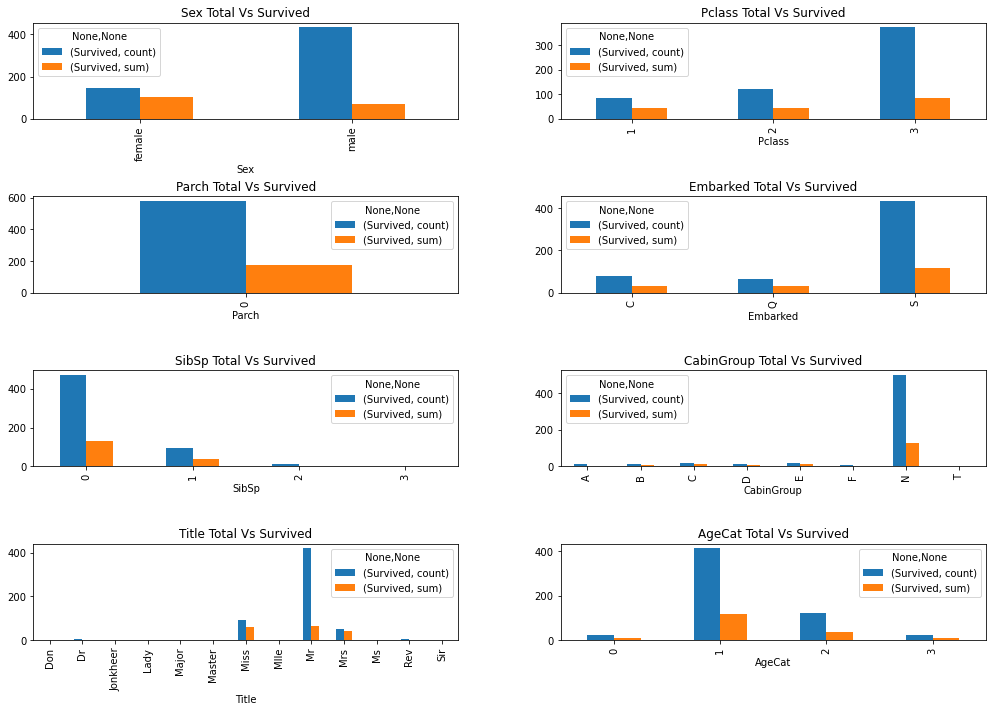

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,axes = plt.subplots(nrows=4,ncols=2)
fig.tight_layout(pad=1.0)
def plot_stat(data,column,ax_pos):
    grouped = data.groupby([column]).agg({'Survived':['count','sum']})
    grouped.plot(kind='bar',title=column+' Total Vs Survived',ax=ax_pos,figsize=(15,10))
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    stat = pd.DataFrame({'Survival_rate':grouped['Survived_sum'].divide(grouped['Survived_count'])*100})
    stat = stat.set_index(column+'_'+stat.index.astype(str))
    return stat

sexBaseSurviveRate = plot_stat(cleaned_train_df,'Sex',axes[0,0])
pclassBaseSurviveRate = plot_stat(cleaned_train_df,'Pclass',axes[0,1])
parchBaseSurviveRate = plot_stat(cleaned_train_df,'Parch',axes[1,0])
embarkedBaseSurviveRate = plot_stat(cleaned_train_df,'Embarked',axes[1,1])
sibSpBaseSurviveRate = plot_stat(cleaned_train_df,'SibSp',axes[2,0])
cabinGroupBaseSurviveRate = plot_stat(cleaned_train_df,'CabinGroup',axes[2,1])
titleBaseSurviveRate = plot_stat(cleaned_train_df,'Title',axes[3,0])
AgeCatBaseSurviveRate = plot_stat(cleaned_train_df,'AgeCat',axes[3,1])


In [47]:
survival_rate_df=sexBaseSurviveRate.append(pclassBaseSurviveRate).append(parchBaseSurviveRate).append(embarkedBaseSurviveRate).append(sibSpBaseSurviveRate).append(cabinGroupBaseSurviveRate).append(titleBaseSurviveRate)
survival_rate_df.sort_values(by=['Survival_rate'],ascending=False)

,Survival_rate
Title_Sir,100.000000
SibSp_3,100.000000
Title_Ms,100.000000
Title_Mlle,100.000000
Title_Master,100.000000
Title_Lady,100.000000
Title_Mrs,81.632653
CabinGroup_E,75.000000
Sex_female,72.413793
CabinGroup_D,66.666667


We can see some cabin groups seems to be having high survival rate

### Modeling[^](#Model)<a id="Model" ></a><br>

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = cleaned_train_df.drop(['Survived','PassengerId','Cabin',"Age","Fare","Parch","SibSp"],axis=1)
X['CabinGroup'] = le.fit_transform(X['CabinGroup'])
X['Embarked'] = le.fit_transform(X['Embarked'])
X['Sex'] = le.fit_transform(X['Sex'])
X['Title'] = le.fit_transform(X['Title'])

Y = cleaned_train_df['Survived']

test_altered = input_test_df.drop(['PassengerId','Ticket',"Parch","SibSp"],axis=1)
test_altered['Cabin'] = test_altered['Cabin'].fillna('NONE')
test_altered['CabinGroup'] = test_altered['Cabin'].str.slice(0,1)
test_altered['CabinGroup'] = le.fit_transform(test_altered['CabinGroup'])
test_altered['Embarked'] = le.fit_transform(test_altered['Embarked'])
test_altered['Sex'] = le.fit_transform(test_altered['Sex'])
test_altered['Title'] = test_altered['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
test_altered['Title'] = le.fit_transform(test_altered['Title'])
test_altered = test_altered.drop('Name',axis=1)
X_predict_test = test_altered.drop(['Cabin','Age','Fare'],axis=1)


In [53]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from xgboost import XGBClassifier

random_state = 20
algorithums = [
    linear_model.LogisticRegressionCV(max_iter = 50000,random_state=random_state),
    linear_model.PassiveAggressiveClassifier(random_state=random_state),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(random_state=random_state),
    linear_model.Perceptron(random_state=random_state),
    
    svm.SVC(max_iter = 500000,probability=True,kernel='linear',C=0.025),
    svm.NuSVC(max_iter = 500000,probability=True),
    svm.LinearSVC(max_iter = 500000),
    
    ensemble.AdaBoostClassifier(random_state=random_state,n_estimators=500,learning_rate=0.75),
    ensemble.BaggingClassifier(random_state=random_state),
    ensemble.ExtraTreesClassifier(random_state=random_state,max_depth=6,min_samples_leaf=2),
    ensemble.GradientBoostingClassifier(random_state=random_state,n_estimators=500,max_depth=6,min_samples_leaf=2),
    ensemble.RandomForestClassifier(random_state=random_state,n_estimators=500,warm_start=True,max_depth=6,min_samples_leaf=2,max_features='sqrt'),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    gaussian_process.GaussianProcessClassifier(),
    
    XGBClassifier(),
    
    neural_network.MLPClassifier(random_state=random_state)
]    

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,cross_validate,ShuffleSplit

result_table_columns = ['Algo','Train Accuracy','Test Accuracy','Fit Time','Score Time']

features = ['Pclass', 'Sex','Embarked', 'AgeCat','FareCat', 'FamilySize', 'CabinGroup','Title']

results = pd.DataFrame(columns=result_table_columns)

def model_stats(algo,X,Y,features,row_index):    
    cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 ) 
    cv_results = cross_validate(algo,X[features],Y,cv=cv_split,return_train_score=True)
    
    algo.fit(X[features],Y)
    
    results.loc[row_index,'Algo'] = algo.__class__.__name__
    results.loc[row_index,'Fit Time'] = cv_results['fit_time'].mean()
    results.loc[row_index,'Score Time'] = cv_results['score_time'].mean()
    results.loc[row_index,'Train Accuracy'] = cv_results['train_score'].mean() *100
    results.loc[row_index,'Test Accuracy'] = cv_results['test_score'].mean()  *100  
    
row_index = 0
for algo in algorithums:
    model_stats(algo,X,Y,features,row_index)
    row_index += 1

results.sort_values(by='Test Accuracy',ascending=False)

,Algo,Train Accuracy,Test Accuracy,Fit Time,Score Time
12,RandomForestClassifier,84.8642,81.6092,0.738108,0.0472373
15,BernoulliNB,80.8889,81.2644,0.00212834,0.000969195
6,NuSVC,81.2099,81.0345,0.0298494,0.00250578
0,LogisticRegressionCV,81.037,80.977,0.276908,0.00119557
7,LinearSVC,81.1852,80.9195,0.127047,0.00135221
2,RidgeClassifierCV,81.1605,80.8621,0.00351899,0.000960875
13,LinearDiscriminantAnalysis,81.1111,80.8046,0.00265889,0.000934291
10,ExtraTreesClassifier,83.8025,80.8046,0.108306,0.0103111
8,AdaBoostClassifier,82.8148,80.5747,0.756686,0.0756421
9,BaggingClassifier,87.9259,80.4023,0.0194806,0.00262592


### Ensemble modeling

In [58]:
vote_est = [
    ('bnb', naive_bayes.BernoulliNB()),
    ('gbc', ensemble.GradientBoostingClassifier(random_state=random_state,n_estimators=500,max_depth=6,min_samples_leaf=2)),
    ('xgb', XGBClassifier()),
    ('ada', ensemble.AdaBoostClassifier(random_state=random_state,n_estimators=500,learning_rate=0.75)),
    ('bc', ensemble.BaggingClassifier(random_state=random_state)),
    ('etc',ensemble.ExtraTreesClassifier(random_state=random_state,max_depth=6,min_samples_leaf=2)), 
    ('rfc', ensemble.RandomForestClassifier(random_state=random_state,n_estimators=500,warm_start=True,max_depth=6,min_samples_leaf=2,max_features='sqrt')),
    ('gpc', gaussian_process.GaussianProcessClassifier()),  
    ('lr', linear_model.LogisticRegressionCV(max_iter = 50000)),  
    ('gnb', naive_bayes.GaussianNB()), 
    ('knn', neighbors.KNeighborsClassifier()), 
    ('svc', svm.SVC(probability=True))
]

#Hard Vote
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 ) 
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = cross_validate(vote_hard, X[features],Y, cv  = cv_split,return_train_score=True)
vote_hard.fit(X[features],Y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = cross_validate(vote_soft, X[features],Y, cv=cv_split,return_train_score=True)
vote_soft.fit(X[features],Y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 85.58
Hard Voting Test w/bin score mean: 81.49
Hard Voting Test w/bin score 3*std: +/- 8.08
----------
Soft Voting Training w/bin score mean: 85.73
Soft Voting Test w/bin score mean: 80.52
Soft Voting Test w/bin score 3*std: +/- 7.00
----------


### Predict[^](#Predict)<a id="Predict" ></a><br>

In [59]:
# bestAlgo = ensemble.RandomForestClassifier(random_state=random_state,n_estimators=500,warm_start=True,max_depth=6,min_samples_leaf=2,max_features='sqrt')
# bestAlgo.fit(X[features],Y)
bestAlgo = vote_hard

Y_trainPredict = bestAlgo.predict(X[features])

Y_predict = bestAlgo.predict(X_predict_test)

print(bestAlgo.score(X[features],Y))

confusion_matrix(Y,Y_trainPredict)

0.8549222797927462


array([[369,  35],
       [ 49, 126]])

### Sumbission[^](#Submission)<a id="Submission" ></a><br>

In [60]:
submission = pd.DataFrame({
        "PassengerId": input_test_df["PassengerId"],
        "Survived": Y_predict
    })
#submission.to_csv('submissionVotingHard.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
